## Imports

In [ ]:
# !pip install kaggle
from pathlib import Path
import json
import shutil
from os import listdir

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as tfb
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


## Helper Functions

#### Download and unzip dataset

In [ ]:
def get_extract_data():

  if Path('food-101').exists():
    print("Dataset already exists")
  else:
    if not Path('food-101.tar.gz').exists():
      print("Dataset does not exist")
      !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    !tar xzvf food-101.tar.gz
    print("Data Extracted")

#### Create train and test dirs

In [ ]:
# Helper to create train and test folders
def create_train_test_dir(src, dst, classes_list, train_json, test_json):
  if Path(dst).exists():
    shutil.rmtree(dst)
  print(f'{str("SET TYPE").ljust(10)} {str("SOURCE").ljust(40)} {str("DESTINATION").ljust(40)}  {str("#FILES").ljust(40)}')
  for c_name in classes_mini:

    train_sub_class_path = Path(dst).joinpath('train').joinpath(c_name)
    test_sub_class_path = Path(dst).joinpath('test').joinpath(c_name)
    
    # create folder for each class
    train_sub_class_path.mkdir(parents=True)
    test_sub_class_path.mkdir(parents=True)

    # Copy files to train
    for f_path in train_json[c_name]:
      shutil.copy(Path(src).joinpath(f_path+'.jpg'), train_sub_class_path)
    print(f'{str("Train").ljust(10)} {str(Path(src).joinpath(c_name)).ljust(40)} {str(train_sub_class_path).ljust(40)}  {len(listdir(train_sub_class_path))}')
    # Copy files to test
    for f_path in test_json[c_name]:
      shutil.copy(Path(src).joinpath(f_path+'.jpg'), test_sub_class_path)
    print(f'{str("Test").ljust(10)} {str(Path(src).joinpath(c_name)).ljust(40)} {str(test_sub_class_path).ljust(40)}  {len(listdir(test_sub_class_path))}')



#### Visualize the dataset

In [ ]:
def view_random_images(dir_, class_list):
  label = ''
  fig, axes = plt.subplots((len(class_list)//6)+1, 6, figsize=(20,20))
  for ax, c_name in zip(axes.ravel(), class_list):
    image_path = random.sample(listdir(Path(dir_).joinpath(c_name)),1)[0] 
    ax.imshow(mpimg.imread(Path(dir_).joinpath(c_name).joinpath(image_path)))
    ax.set_title(c_name.replace('_', ' ').capitalize())
    ax.set_axis_off()
  fig.delaxes(axes[16][5])
  plt.tight_layout()

#### Plot Loss Curves using Model's history callback

In [ ]:
def plot_loss_curves(history):
  epochs = range(1, len(history.history['loss'])+1)
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.plot(epochs, history.history['loss'], label='Training Loss')
  plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(122)
  plt.plot(epochs, history.history['accuracy'], label='Training accuracy')
  plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


### Plot loss curves between 2 models

In [ ]:
# def plot_and_compare_loss_curves(history_list, model_names):
   
#   epochs = range(1, len(history.history['loss'])+1)
#   fig, axes = plt.subplots(2,2,True,True,figsize=(20,5))
#   for history in history_list:
#   for ax in axes.ravel():
#     ax.plot(epochs, history.history['loss'], label='Training Loss')
#     ax.plot(epochs, history.history['val_loss'], label='Validation Loss')
#     ax.set_title(c_name.replace('_', ' ').capitalize())
#     ax.xlabel('Epochs')
#     ax.ylabel('Loss')
#   fig.show()


## Data

- The [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset has 101000 images of food with 101 classes.
- Each class has 1000 samples divided into 750 training samples and 250 test samples.
> 📝 **Note:** From Food-101 webpage:
On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
The entire dataset is 5GB in size

### Download and Unzip data

In [ ]:
get_extract_data()

Dataset already exists


### Create Train and Test Directories

The downloaded data is in a single directory (namely **Food-101**), with sub-folder names as class name, which is fine if we only want to train the model. But usually it's not the case. So we'll create 2 directory under a dir **dataset** each with sub_dirs: ***lasagna, macaroni_and_cheese, pizza, caprese_salad, club_sandwich, dumplings, french_onion_soup, tacos, ramen, spaghetti_bolognese***

The dir structure will be:
```
├── root
│   ├── dataset
│   │   ├── train
|   │   |   ├── lasagna
|   │   |   ├── macaroni_and_cheese
|   │   |   ├── ...
|   │   |
|   |   ├── test
|   │   |   ├── lasagna
|   │   |   ├── macaroni_and_cheese
|   │   |   ├── ...
|   │   |
|   |   ├── Food-101
|   │   |   ├── images
|   │   |   ├── meta
|   │   |   ├── ...
|   |   ├── food-101.tar.gz

```

#### Getting image file names, classes and labels

These informations are stored under

```Food-101 --> meta```

The file:
- labels.txt contains labels
- classes.txt contains classes
- train.json contains key, values pairs. keys = classes and values = image path
- test.json contains key, values pairs. keys = classes and values = image path

> 📝 **Note:** **```test.json```** contains 250 handpicked images (in each class) path. This is good for testing our model

In [ ]:
train_file = 'food-101/meta/train.json'
test_file = 'food-101/meta/test.json'
classes_file = 'food-101/meta/classes.txt'
labels_file = 'food-101/meta/labels.txt'


with open("food-101/meta/train.json", "r") as f:
    train_json = json.loads(f.read())
with open("food-101/meta/test.json", "r") as f:
    test_json = json.loads(f.read())
with open("food-101/meta/classes.txt", "r") as f:
    classes = f.read()
    classes = classes.strip('\n').split('\n')
with open("food-101/meta/labels.txt", "r") as f:
  labels = f.read()
  labels = labels.strip('\n').split('\n')


In [ ]:
# List sub-dirs of food-101/images with size
total = 0
print('DIRECTORY PATH'.ljust(50), 'SIZE')
for sub_path in Path('food-101/images').iterdir():
  total+=sub_path.stat().st_size
  print(str(sub_path).ljust(50), str(round(sub_path.stat().st_size*0.001, 2))+" kb")
print('\n'+str('TOTAL').ljust(50), str(round(total*0.001, 2))+" kb")

DIRECTORY PATH                                     SIZE
food-101/images/oysters                            36.86 kb
food-101/images/red_velvet_cake                    36.86 kb
food-101/images/clam_chowder                       32.77 kb
food-101/images/baklava                            36.86 kb
food-101/images/beef_carpaccio                     36.86 kb
food-101/images/hot_and_sour_soup                  36.86 kb
food-101/images/macaroni_and_cheese                36.86 kb
food-101/images/samosa                             36.86 kb
food-101/images/ice_cream                          36.86 kb
food-101/images/omelette                           36.86 kb
food-101/images/edamame                            36.86 kb
food-101/images/miso_soup                          36.86 kb
food-101/images/mussels                            36.86 kb
food-101/images/peking_duck                        36.86 kb
food-101/images/beignets                           36.86 kb
food-101/images/chicken_quesadilla          

#### Function to create train-test dirs

In [ ]:
# Initially, we usually don't train the model on huge dataset
# because we want to understand how our model is performing on
# subset of dataset. Then, ones the results are satisfactory,
# we can up the model by providing the whole dataset.

# Ergo, create mini classes
classes_mini = [
               'caprese_salad',
               'club_sandwich',
               'dumplings',
               'french_onion_soup',
               'lasagna',
               'macaroni_and_cheese',
               'pizza',
               'ramen',
               'spaghetti_bolognese',
               'tacos',
               ]



src = 'food-101/images'
dst = 'dataset'
create_train_test_dir(src, dst, classes_mini, train_json, test_json)

SET TYPE   SOURCE                                   DESTINATION                               #FILES                                  
Train      food-101/images/caprese_salad            dataset/train/caprese_salad               750
Test       food-101/images/caprese_salad            dataset/test/caprese_salad                250
Train      food-101/images/club_sandwich            dataset/train/club_sandwich               750
Test       food-101/images/club_sandwich            dataset/test/club_sandwich                250
Train      food-101/images/dumplings                dataset/train/dumplings                   750
Test       food-101/images/dumplings                dataset/test/dumplings                    250
Train      food-101/images/french_onion_soup        dataset/train/french_onion_soup           750
Test       food-101/images/french_onion_soup        dataset/test/french_onion_soup            250
Train      food-101/images/lasagna                  dataset/train/lasagna        

### Visualize

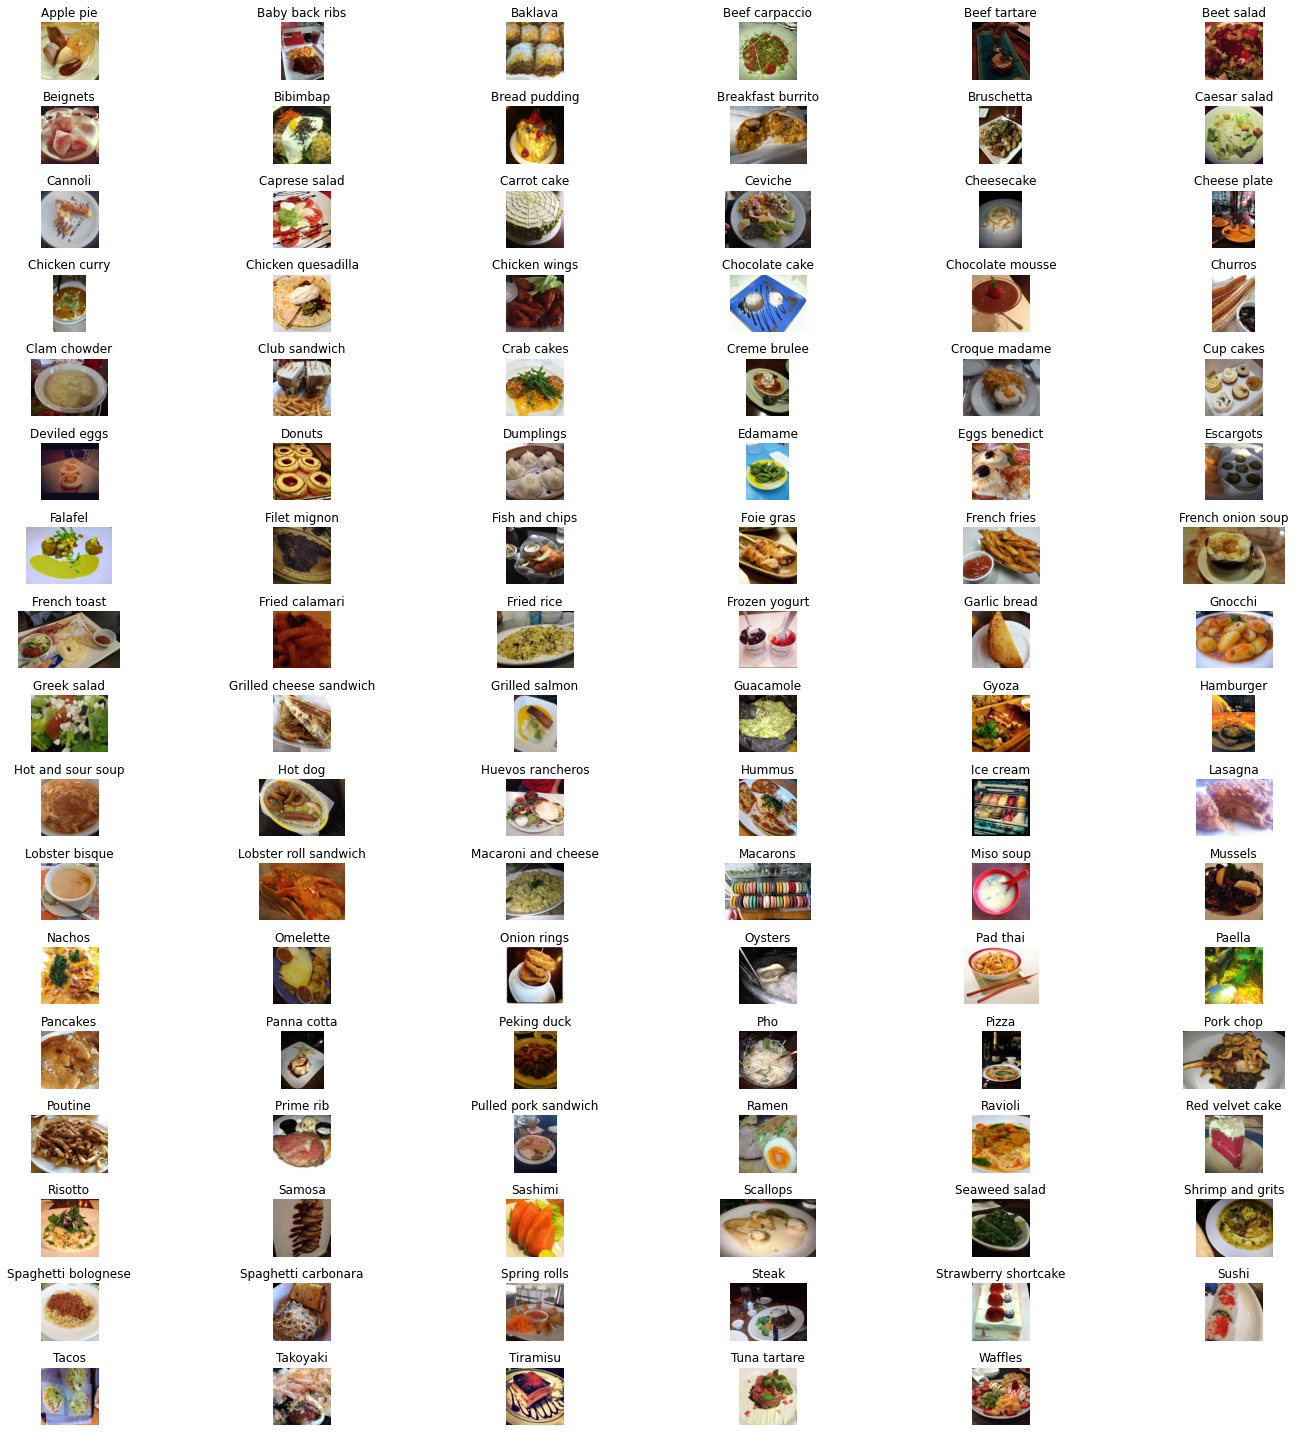

In [ ]:
view_random_images('food-101/images', classes)

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

https://www.kaggle.com/srajanseth/food-vision-51/notebook

### Prepare data for model

Here we're perfoming **data augmentation** — increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data, using tensorflow's **ImageDataGenerator** class. Then we'll pass the generated images to tensorflow's **flow_from_directory** method which will take images as predictor and directory name as class (i.e. response).

In [ ]:
tfb.clear_session()

# Setup the train and test directories
train_dir = str(Path(Path.cwd()).joinpath('dataset').joinpath('train'))
test_dir = str(Path(Path.cwd()).joinpath('dataset').joinpath('test'))

# Preprocess data (scaling i.e. normalize)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
HEIGHT, WIDTH, N_COLOR = 224,224,3
BATCH_SIZE = 128
n_classes = 10
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               target_size=(HEIGHT, WIDTH), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=(HEIGHT, WIDTH),
                                               class_mode="categorical",
                                               seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Baseline Model

#### Create and compile

In [ ]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
baseline_model = tf.keras.Sequential([
                                      InputLayer(
                                          input_shape=(HEIGHT, WIDTH, N_COLOR),
                                          # batch_size=BATCH_SIZE,
                                          name='Input'
                                          ),
                                      Conv2D(
                                          filters=10,
                                          kernel_size=3,
                                          activation='relu',
                                          #  input_shape=(HEIGHT, WIDTH, N_COLOR),
                                          name='CONV_1'
                                          ),
                                      Conv2D(
                                          filters=10,
                                          kernel_size=3,
                                          activation='relu',
                                          name='CONV_2'
                                          ),
                                      MaxPool2D(
                                          pool_size=2,
                                          name='POOL_1'
                                          ),
                                      Conv2D(
                                          filters=10,
                                          kernel_size=3,
                                          activation='relu',
                                          name='CONV_3'
                                          ),
                                      Conv2D(
                                          filters=10,
                                          kernel_size=3,
                                          activation='relu',
                                          name='CONV_4'
                                          ),
                                      MaxPool2D(
                                          pool_size=2,
                                          name='POOL_2'
                                          ),
                                      Flatten(),
                                      Dense(
                                          units=10,
                                          activation='softmax',
                                          name='Output'
                                          )
                                      ])

baseline_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 CONV_2 (Conv2D)             (None, 220, 220, 10)      910       
                                                                 
 POOL_1 (MaxPooling2D)       (None, 110, 110, 10)      0         
                                                                 
 CONV_3 (Conv2D)             (None, 108, 108, 10)      910       
                                                                 
 CONV_4 (Conv2D)             (None, 106, 106, 10)      910       
                                                                 
 POOL_2 (MaxPooling2D)       (None, 53, 53, 10)        0         
                                                                 
 flatten (Flatten)           (None, 28090)             0

In [ ]:
# plot_model(baseline_model, show_shapes=True, show_dtype=True)

#### Fit

In [ ]:
# Fit the model
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
baseline_history = baseline_model.fit(
    train_data,
    epochs=50,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps=int(0.1*len(test_data)),
    callbacks=[
              EarlyStopping,
    ]
    )

Epoch 1/50
59/59 [==============================] - 47s 737ms/step - loss: 2.2192 - accuracy: 0.1733 - val_loss: 2.0552 - val_accuracy: 0.2578
Epoch 2/50
59/59 [==============================] - 42s 711ms/step - loss: 1.9059 - accuracy: 0.3409 - val_loss: 1.7979 - val_accuracy: 0.3789
Epoch 3/50
59/59 [==============================] - 41s 693ms/step - loss: 1.6932 - accuracy: 0.4223 - val_loss: 1.7561 - val_accuracy: 0.3359
Epoch 4/50
59/59 [==============================] - 42s 706ms/step - loss: 1.4216 - accuracy: 0.5237 - val_loss: 1.9965 - val_accuracy: 0.3359
Epoch 5/50
59/59 [==============================] - 42s 704ms/step - loss: 1.0761 - accuracy: 0.6540 - val_loss: 2.1692 - val_accuracy: 0.3438
Epoch 6/50
59/59 [==============================] - 41s 694ms/step - loss: 0.7269 - accuracy: 0.7635 - val_loss: 2.3951 - val_accuracy: 0.2930
Epoch 7/50
59/59 [==============================] - 41s 705ms/step - loss: 0.4099 - accuracy: 0.8793 - val_loss: 2.6114 - val_accuracy: 0.3555

#### Plot loss curves

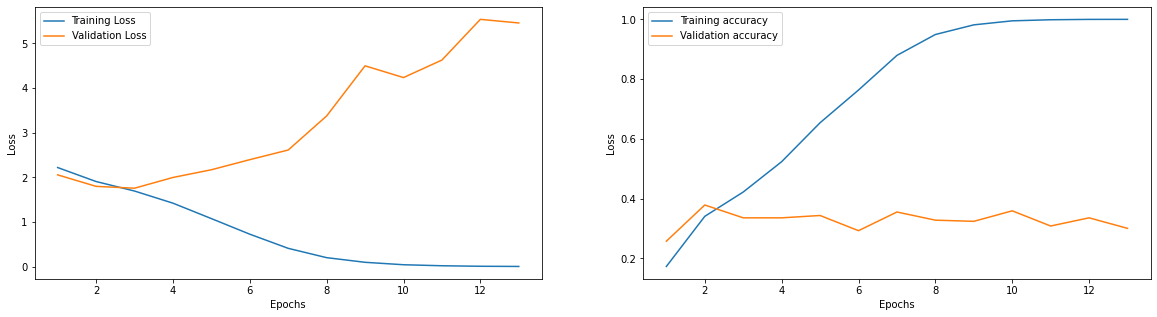

In [ ]:
plot_loss_curves(baseline_history)

#### Evaluate

## Model

#### Create & Compile

In [ ]:
model = tf.keras.Sequential([
                              InputLayer(
                                  input_shape=(HEIGHT, WIDTH, N_COLOR),
                                  # batch_size=BATCH_SIZE,
                                  name='Input'
                                  ),
                              Conv2D(
                                  filters=16,
                                  kernel_size=5,
                                  activation='relu',
                                  #  input_shape=(HEIGHT, WIDTH, N_COLOR),
                                  name='CONV_1'
                                  ),
                              Conv2D(
                                  filters=32,
                                  kernel_size=5,
                                  activation='relu',
                                  name='CONV_2'
                                  ),
                              MaxPool2D(
                                  pool_size=2,
                                  name='POOL_1'
                                  ),
                              Conv2D(
                                  filters=64,
                                  kernel_size=5,
                                  padding='same',
                                  activation='relu',
                                  name='CONV_3'
                                  ),
                              Conv2D(
                                  filters=128,
                                  kernel_size=5,
                                  activation='relu',
                                  name='CONV_4'
                                  ),
                              MaxPool2D(
                                  pool_size=2,
                                  name='POOL_2'
                                  ),
                              Flatten(),
                              Dense(
                                  units=10,
                                  activation='softmax',
                                  name='Output'
                                  )
                              ])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 POOL_1 (MaxPooling2D)       (None, 111, 111, 10)      0         
                                                                 
 CONV_3 (Conv2D)             (None, 111, 111, 16)      1456      
                                                                 
 POOL_2 (MaxPooling2D)       (None, 55, 55, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 48400)             0         
                                                                 
 Output (Dense)              (None, 10)                484010    
                                                                 
Total params: 485,746
Trainable params: 485,746
Non-tr

#### Fit

In [ ]:
# Fit the model
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    train_data,
    epochs=50,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps=int(0.1*len(test_data)),
    callbacks=[
              EarlyStopping,
    ]
    )

Epoch 1/50
59/59 [==============================] - 39s 644ms/step - loss: 2.2250 - accuracy: 0.2296 - val_loss: 1.9126 - val_accuracy: 0.2969
Epoch 2/50
59/59 [==============================] - 37s 628ms/step - loss: 1.8097 - accuracy: 0.3873 - val_loss: 1.7686 - val_accuracy: 0.3945
Epoch 3/50
59/59 [==============================] - 37s 623ms/step - loss: 1.5347 - accuracy: 0.4948 - val_loss: 1.7276 - val_accuracy: 0.4219
Epoch 4/50
59/59 [==============================] - 37s 632ms/step - loss: 1.2569 - accuracy: 0.6033 - val_loss: 1.6860 - val_accuracy: 0.4336
Epoch 5/50
59/59 [==============================] - 37s 623ms/step - loss: 0.9674 - accuracy: 0.7128 - val_loss: 1.7743 - val_accuracy: 0.3750
Epoch 6/50
59/59 [==============================] - 37s 631ms/step - loss: 0.6573 - accuracy: 0.8195 - val_loss: 1.8337 - val_accuracy: 0.4453
Epoch 7/50
59/59 [==============================] - 38s 643ms/step - loss: 0.4346 - accuracy: 0.8924 - val_loss: 2.0460 - val_accuracy: 0.4180

#### Plot loss curves

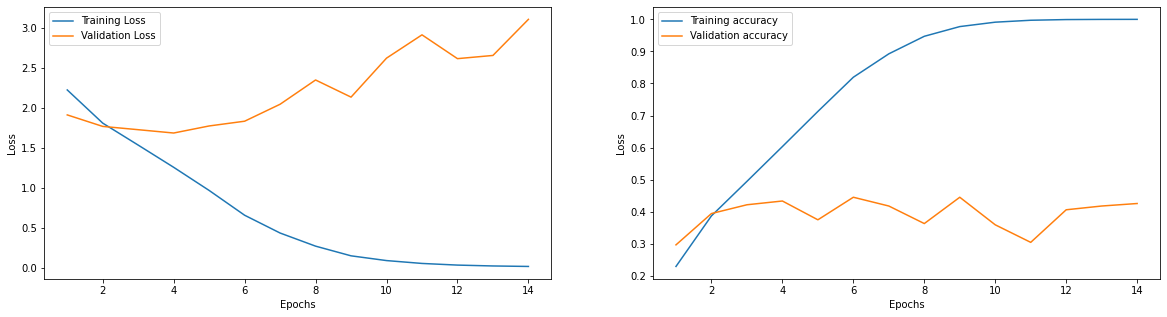

In [ ]:
plot_loss_curves(history)

#### Evaluate

## Loss curve: Baseline vs. Model

In [ ]:
# plot_and_compare_loss_curves(history)